# Preprocessing

### Importing Libraries and Data

In [ ]:
# data
import nfl_data_py as nfl

# data loading and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# models
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# interpretation
import shap
from interpret import show

# pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, nan_euclidean_distances

In [345]:
df_weekly = nfl.import_weekly_data([2019, 2020, 2021, 2022, 2023])
df_draft = nfl.import_draft_picks(list(range(1994, 2024)))
df_schedule = nfl.import_schedules([2019, 2020, 2021, 2022, 2023, 2024])

df_weekly = df_weekly[df_weekly['season_type'] == 'REG']

Downcasting floats.


In [346]:
df_weekly['game_id_home_away'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['recent_team']+'_'+df_weekly['opponent_team']
df_weekly['game_id_away_home'] = df_weekly['season'].astype(str) + '_' + df_weekly['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly['opponent_team']+'_'+df_weekly['recent_team']
df_draft = df_draft.rename(columns={'gsis_id': 'player_id'})

In [347]:
df_merged = pd.melt(
    df_weekly,
    id_vars=['player_id', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'fantasy_points'],
    value_vars=['game_id_home_away', 'game_id_away_home'],
    var_name='game_id_type',
    value_name='game_id'
)

In [348]:
df_merged = pd.merge(df_merged[['player_id', 'position', 'season', 'week', 'game_id', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'fantasy_points']], df_draft[['player_id', 'pick']], on = 'player_id', how = 'left')
df_merged = pd.merge(df_merged, df_schedule[['game_id', 'home_team', 'roof', 'surface', 'wind', 'temp']], on='game_id', how='inner')

df_merged = df_merged.drop(columns='game_id')


### Data exploration

In [349]:
df_merged.columns

Index(['player_id', 'position', 'season', 'week', 'recent_team',
       'opponent_team', 'completions', 'attempts', 'passing_yards',
       'passing_tds', 'passing_2pt_conversions', 'interceptions',
       'sack_fumbles_lost', 'carries', 'rushing_yards', 'rushing_tds',
       'rushing_2pt_conversions', 'rushing_fumbles_lost', 'receptions',
       'targets', 'receiving_yards', 'receiving_tds',
       'receiving_2pt_conversions', 'receiving_fumbles_lost', 'fantasy_points',
       'pick', 'home_team', 'roof', 'surface', 'wind', 'temp'],
      dtype='object')

In [350]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26129 entries, 0 to 26128
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   player_id                  26129 non-null  object 
 1   position                   26129 non-null  object 
 2   season                     26129 non-null  int32  
 3   week                       26129 non-null  int32  
 4   recent_team                26129 non-null  object 
 5   opponent_team              26129 non-null  object 
 6   completions                26129 non-null  int32  
 7   attempts                   26129 non-null  int32  
 8   passing_yards              26129 non-null  float32
 9   passing_tds                26129 non-null  int32  
 10  passing_2pt_conversions    26129 non-null  int32  
 11  interceptions              26129 non-null  float32
 12  sack_fumbles_lost          26129 non-null  int32  
 13  carries                    26129 non-null  int

In [351]:
df_merged.head()

,player_id,position,season,week,recent_team,opponent_team,completions,attempts,passing_yards,passing_tds,...,receiving_tds,receiving_2pt_conversions,receiving_fumbles_lost,fantasy_points,pick,home_team,roof,surface,wind,temp
0,00-0019596,QB,2019,2,NE,MIA,20,28,264.0,2,...,0,0,0.0,24.66,199.0,MIA,outdoors,grass,4.0,87.0
1,00-0019596,QB,2019,4,NE,BUF,18,39,150.0,0,...,0,0,0.0,3.70,199.0,BUF,outdoors,astroturf,10.0,58.0
2,00-0019596,QB,2019,5,NE,WAS,28,42,348.0,3,...,0,0,0.0,23.92,199.0,WAS,outdoors,grass,8.0,70.0
3,00-0019596,QB,2019,7,NE,NYJ,31,45,249.0,1,...,0,0,0.0,11.96,199.0,NYJ,outdoors,fieldturf,0.0,58.0
4,00-0019596,QB,2019,9,NE,BAL,30,46,285.0,1,...,0,0,0.0,13.40,199.0,BAL,outdoors,grass,1.0,48.0


In [352]:
df_merged.isnull().sum()

player_id                        0
position                         0
season                           0
week                             0
recent_team                      0
opponent_team                    0
completions                      0
attempts                         0
passing_yards                    0
passing_tds                      0
passing_2pt_conversions          0
interceptions                    0
sack_fumbles_lost                0
carries                          0
rushing_yards                    0
rushing_tds                      0
rushing_2pt_conversions          0
rushing_fumbles_lost             0
receptions                       0
targets                          0
receiving_yards                  0
receiving_tds                    0
receiving_2pt_conversions        0
receiving_fumbles_lost           0
fantasy_points                   0
pick                          5630
home_team                        0
roof                             0
surface             

### Feature Engineering

In [353]:
print(df_merged[df_merged['pick'].isna()])

        player_id position  season  week recent_team opponent_team  \
105    00-0025708       QB    2019     1          KC           JAX   
106    00-0025708       QB    2019     7          KC           DEN   
107    00-0025708       QB    2019    16          KC           CHI   
108    00-0026035       WR    2019     1         DET           ARI   
109    00-0026035       WR    2019     3         DET           PHI   
...           ...      ...     ...   ...         ...           ...   
25919  00-0038809       TE    2023    15          GB            TB   
25920  00-0038821       WR    2023     2          TB           CHI   
25921  00-0038821       WR    2023     7          TB           ATL   
25948  00-0038951       RB    2023     2          TB           CHI   
25949  00-0038951       RB    2023     3          TB           PHI   

       completions  attempts  passing_yards  passing_tds  ...  receiving_tds  \
105              0         1            0.0            0  ...              0   

In [354]:
df_merged['pick'] = df_merged['pick'].fillna(260)

In [355]:
df_merged['wind'] = df_merged.groupby(['home_team', 'week'])['wind'].transform(lambda x: x.fillna(x.mean()))
df_merged['temp'] = df_merged.groupby(['home_team', 'week'])['temp'].transform(lambda x: x.fillna(x.mean()))
df_merged['wind'] = df_merged['wind'].fillna(df_merged['wind'].median())
df_merged['temp'] = df_merged['temp'].fillna(df_merged['temp'].median())

In [356]:
df_merged['surface'] = df_merged['surface'].fillna('unknown')

In [357]:
df_merged['turnover'] = (
    df_merged['interceptions'] +
    df_merged['sack_fumbles_lost'] +
    df_merged['rushing_fumbles_lost'] +
    df_merged['receiving_fumbles_lost']
)

df_merged = df_merged.drop(columns=['interceptions', 'sack_fumbles_lost', 'rushing_fumbles_lost', 'receiving_fumbles_lost'])

In [358]:
df_merged['rushing_pts'] = (df_merged['rushing_tds'] * 6) + (df_merged['rushing_2pt_conversions'] * 2)
df_merged['receiving_pts'] = (df_merged['receiving_tds'] * 6) + (df_merged['receiving_2pt_conversions'] * 2)
df_merged['passing_pts'] = (df_merged['passing_tds'] * 6) + (df_merged['passing_2pt_conversions'] * 2)

df_merged = df_merged.drop(columns=['rushing_tds', 'rushing_2pt_conversions', 'receiving_tds', 'receiving_2pt_conversions', 'passing_tds', 'passing_2pt_conversions'])
df_merged

,player_id,position,season,week,recent_team,opponent_team,completions,attempts,passing_yards,carries,...,pick,home_team,roof,surface,wind,temp,turnover,rushing_pts,receiving_pts,passing_pts
0,00-0019596,QB,2019,2,NE,MIA,20,28,264.0,2,...,199.0,MIA,outdoors,grass,4.0,87.0,0.0,6,0,12
1,00-0019596,QB,2019,4,NE,BUF,18,39,150.0,3,...,199.0,BUF,outdoors,astroturf,10.0,58.0,1.0,0,0,0
2,00-0019596,QB,2019,5,NE,WAS,28,42,348.0,0,...,199.0,WAS,outdoors,grass,8.0,70.0,1.0,0,0,18
3,00-0019596,QB,2019,7,NE,NYJ,31,45,249.0,0,...,199.0,NYJ,outdoors,fieldturf,0.0,58.0,1.0,0,0,6
4,00-0019596,QB,2019,9,NE,BAL,30,46,285.0,0,...,199.0,BAL,outdoors,grass,1.0,48.0,1.0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26124,00-0039165,RB,2023,8,SEA,CLE,0,0,0.0,5,...,52.0,SEA,outdoors,fieldturf,3.0,47.0,0.0,0,0,0
26125,00-0039165,RB,2023,10,SEA,WAS,0,0,0.0,6,...,52.0,SEA,outdoors,fieldturf,4.0,52.0,0.0,0,0,0
26126,00-0039165,RB,2023,12,SEA,SF,0,0,0.0,14,...,52.0,SEA,outdoors,fieldturf,4.0,39.0,0.0,0,0,0
26127,00-0039165,RB,2023,15,SEA,PHI,0,0,0.0,4,...,52.0,SEA,outdoors,fieldturf,2.0,46.0,0.0,0,0,0


In [359]:
# Spalten, für die die EWM-Werte berechnet werden sollen
ewm_columns = ['completions', 'attempts', 'passing_yards', 'carries',
               'rushing_yards', 'receptions', 'targets', 'receiving_yards',
               'fantasy_points', 'turnover', 'rushing_pts', 'receiving_pts', 'passing_pts']

# Sortieren der Daten nach player_id, season und week
df_merged = df_merged.sort_values(by=['player_id', 'season', 'week'])

# Funktion, um die EWM-Werte für jede Gruppe (pro Spieler) zu berechnen
def calculate_ewm_features(group, columns, alpha=0.5):
    ewm_result = pd.DataFrame(index=group.index)
    
    for col in columns:
        # Temporärer Platzhalter für die berechneten EWM-Werte
        temp_ewm = []
        # Iteration durch jede Zeile der Gruppe
        for i in range(len(group)):
            # Subset der Daten bis zur vorherigen Woche
            historical_data = group.iloc[:i]
            # EWM nur auf historische Daten anwenden
            temp_ewm.append(historical_data[col].ewm(alpha=alpha).mean().iloc[-1] if not historical_data.empty else np.nan)
        # Ergebnis hinzufügen
        ewm_result[f'ewm_{col}'] = temp_ewm
    
    return pd.concat([group.reset_index(drop=True), ewm_result.reset_index(drop=True)], axis=1)


# EWM-Werte für jede Spielergruppe berechnen
df_merged = df_merged.groupby('player_id').apply(calculate_ewm_features, columns=ewm_columns).reset_index(drop=True)

/var/folders/sn/54gnf37x14l2fsfqr_hj0dnc0000gn/T/ipykernel_20787/118051308.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merged = df_merged.groupby('player_id').apply(calculate_ewm_features, columns=ewm_columns).reset_index(drop=True)


In [360]:
df_merged.isnull().sum()

player_id                 0
position                  0
season                    0
week                      0
recent_team               0
opponent_team             0
completions               0
attempts                  0
passing_yards             0
carries                   0
rushing_yards             0
receptions                0
targets                   0
receiving_yards           0
fantasy_points            0
pick                      0
home_team                 0
roof                      0
surface                   0
wind                      0
temp                      0
turnover                  0
rushing_pts               0
receiving_pts             0
passing_pts               0
ewm_completions        1206
ewm_attempts           1206
ewm_passing_yards      1206
ewm_carries            1206
ewm_rushing_yards      1206
ewm_receptions         1206
ewm_targets            1206
ewm_receiving_yards    1206
ewm_fantasy_points     1206
ewm_turnover           1206
ewm_rushing_pts     

In [361]:
df_merged['player_id'].nunique()
df_merged

,player_id,position,season,week,recent_team,opponent_team,completions,attempts,passing_yards,carries,...,ewm_carries,ewm_rushing_yards,ewm_receptions,ewm_targets,ewm_receiving_yards,ewm_fantasy_points,ewm_turnover,ewm_rushing_pts,ewm_receiving_pts,ewm_passing_pts
0,00-0019596,QB,2019,1,NE,PIT,24,36,341.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00-0019596,QB,2019,2,NE,MIA,20,28,264.0,2,...,0.000000,0.000000,0.000000,0.000000,0.000000,25.639999,0.000000,0.000000,0.0,18.000000
2,00-0019596,QB,2019,3,NE,NYJ,28,42,306.0,2,...,1.333333,0.666667,0.000000,0.000000,0.000000,24.986666,0.000000,4.000000,0.0,14.000000
3,00-0019596,QB,2019,4,NE,BUF,18,39,150.0,3,...,1.714286,-0.285714,0.000000,0.000000,0.000000,22.217142,0.000000,1.714286,0.0,12.857143
4,00-0019596,QB,2019,5,NE,WAS,28,42,348.0,0,...,2.400000,-1.733333,0.000000,0.000000,0.000000,12.341333,0.533333,0.800000,0.0,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26124,00-0039165,RB,2023,14,SEA,SF,0,0,0.0,9,...,15.518808,51.749389,2.587201,3.159746,26.622374,10.838642,0.000000,3.001466,0.0,0.000000
26125,00-0039165,RB,2023,15,SEA,PHI,0,0,0.0,4,...,12.258608,47.873748,1.793407,2.079609,15.308425,7.818584,0.000000,1.500366,0.0,0.000000
26126,00-0039165,RB,2023,16,SEA,TEN,0,0,0.0,2,...,8.128800,31.934929,0.896594,1.539739,7.653278,4.708912,0.000000,0.750092,0.0,0.000000
26127,00-0039165,RB,2023,17,SEA,PIT,0,0,0.0,2,...,5.064213,15.966490,0.948300,1.769883,1.826283,2.154300,0.000000,0.375023,0.0,0.000000


In [362]:
df_merged[[col for col in df_merged.columns if col.startswith('ewm')]] = df_merged[[col for col in df_merged.columns if col.startswith('ewm')]].fillna(0)

In [363]:
# Ausgabe der neuen Spalten
print(df_merged[['player_id', 'season', 'week', 'ewm_passing_yards', 'passing_yards', 'ewm_rushing_yards', 'rushing_yards']].head())

    player_id  season  week  ewm_passing_yards  passing_yards  \
0  00-0019596    2019     1           0.000000          341.0   
1  00-0019596    2019     2         341.000000          264.0   
2  00-0019596    2019     3         289.666667          306.0   
3  00-0019596    2019     4         299.000000          150.0   
4  00-0019596    2019     5         219.533333          348.0   

   ewm_rushing_yards  rushing_yards  
0           0.000000            0.0  
1           0.000000            1.0  
2           0.666667           -1.0  
3          -0.285714           -3.0  
4          -1.733333            0.0  


In [364]:
df_merged = df_merged.drop(columns=['completions', 'attempts', 'passing_yards', 'carries', 'rushing_yards', 'receptions', 'targets', 
                                    'receiving_yards', 'turnover', 'rushing_pts', 'receiving_pts', 'passing_pts'])

In [365]:
df_merged.head()

,player_id,position,season,week,recent_team,opponent_team,fantasy_points,pick,home_team,roof,...,ewm_carries,ewm_rushing_yards,ewm_receptions,ewm_targets,ewm_receiving_yards,ewm_fantasy_points,ewm_turnover,ewm_rushing_pts,ewm_receiving_pts,ewm_passing_pts
0,00-0019596,QB,2019,1,NE,PIT,25.639999,199.0,NE,outdoors,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
1,00-0019596,QB,2019,2,NE,MIA,24.660000,199.0,MIA,outdoors,...,0.000000,0.000000,0.0,0.0,0.0,25.639999,0.000000,0.000000,0.0,18.000000
2,00-0019596,QB,2019,3,NE,NYJ,20.139999,199.0,NE,outdoors,...,1.333333,0.666667,0.0,0.0,0.0,24.986666,0.000000,4.000000,0.0,14.000000
3,00-0019596,QB,2019,4,NE,BUF,3.700000,199.0,BUF,outdoors,...,1.714286,-0.285714,0.0,0.0,0.0,22.217142,0.000000,1.714286,0.0,12.857143
4,00-0019596,QB,2019,5,NE,WAS,23.920000,199.0,WAS,outdoors,...,2.400000,-1.733333,0.0,0.0,0.0,12.341333,0.533333,0.800000,0.0,6.000000


In [366]:
df_merged['player_id'] = df_merged['player_id'].str.replace('00-00', '').astype(int)

In [367]:
df_merged['home'] = (df_merged['home_team'] == df_merged['recent_team']).astype(int)
df_merged = df_merged.drop(columns=['home_team'])

### Feature Selection

In [368]:
X = df_merged.drop(columns=['fantasy_points'])
X

,player_id,position,season,week,recent_team,opponent_team,pick,roof,surface,wind,...,ewm_rushing_yards,ewm_receptions,ewm_targets,ewm_receiving_yards,ewm_fantasy_points,ewm_turnover,ewm_rushing_pts,ewm_receiving_pts,ewm_passing_pts,home
0,19596,QB,2019,1,NE,PIT,199.0,outdoors,grass,2.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1
1,19596,QB,2019,2,NE,MIA,199.0,outdoors,grass,4.0,...,0.000000,0.000000,0.000000,0.000000,25.639999,0.000000,0.000000,0.0,18.000000,0
2,19596,QB,2019,3,NE,NYJ,199.0,outdoors,grass,10.0,...,0.666667,0.000000,0.000000,0.000000,24.986666,0.000000,4.000000,0.0,14.000000,1
3,19596,QB,2019,4,NE,BUF,199.0,outdoors,astroturf,10.0,...,-0.285714,0.000000,0.000000,0.000000,22.217142,0.000000,1.714286,0.0,12.857143,0
4,19596,QB,2019,5,NE,WAS,199.0,outdoors,grass,8.0,...,-1.733333,0.000000,0.000000,0.000000,12.341333,0.533333,0.800000,0.0,6.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26124,39165,RB,2023,14,SEA,SF,52.0,outdoors,grass,5.0,...,51.749389,2.587201,3.159746,26.622374,10.838642,0.000000,3.001466,0.0,0.000000,0
26125,39165,RB,2023,15,SEA,PHI,52.0,outdoors,fieldturf,2.0,...,47.873748,1.793407,2.079609,15.308425,7.818584,0.000000,1.500366,0.0,0.000000,1
26126,39165,RB,2023,16,SEA,TEN,52.0,outdoors,grass,4.0,...,31.934929,0.896594,1.539739,7.653278,4.708912,0.000000,0.750092,0.0,0.000000,0
26127,39165,RB,2023,17,SEA,PIT,52.0,outdoors,fieldturf,4.0,...,15.966490,0.948300,1.769883,1.826283,2.154300,0.000000,0.375023,0.0,0.000000,1


In [369]:
y = df_merged['fantasy_points']
y

0        25.639999
1        24.660000
2        20.139999
3         3.700000
4        23.920000
           ...    
26124     4.800000
26125     1.600000
26126    -0.400000
26127     4.100000
26128     6.000000
Name: fantasy_points, Length: 26129, dtype: float32

### Data Splitting

In [370]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20903 entries, 16844 to 23654
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player_id            20903 non-null  int64  
 1   position             20903 non-null  object 
 2   season               20903 non-null  int32  
 3   week                 20903 non-null  int32  
 4   recent_team          20903 non-null  object 
 5   opponent_team        20903 non-null  object 
 6   pick                 20903 non-null  float64
 7   roof                 20903 non-null  object 
 8   surface              20903 non-null  object 
 9   wind                 20903 non-null  float64
 10  temp                 20903 non-null  float64
 11  ewm_completions      20903 non-null  float64
 12  ewm_attempts         20903 non-null  float64
 13  ewm_passing_yards    20903 non-null  float64
 14  ewm_carries          20903 non-null  float64
 15  ewm_rushing_yards    20903 non-null  

# Pipeline

In [371]:
categorical_features = ['position', 'opponent_team', 'recent_team', 'roof', 'surface']
numeric_features = list(set(X.columns) - set(categorical_features))
numeric_features

['ewm_fantasy_points',
 'ewm_receptions',
 'season',
 'ewm_passing_pts',
 'pick',
 'temp',
 'ewm_turnover',
 'ewm_targets',
 'home',
 'player_id',
 'ewm_receiving_yards',
 'week',
 'ewm_passing_yards',
 'ewm_attempts',
 'ewm_rushing_yards',
 'ewm_rushing_pts',
 'ewm_carries',
 'wind',
 'ewm_completions',
 'ewm_receiving_pts']

In [372]:
preprocessor = ColumnTransformer(transformers=[
    ("num", SimpleImputer(strategy="median"), numeric_features),
    ("cat", OneHotEncoder(drop = 'first', sparse_output=False), categorical_features), 
])

In [373]:
xgb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42))
])

In [374]:
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['ewm_fantasy_points',
                                                   'ewm_receptions', 'season',
                                                   'ewm_passing_pts', 'pick',
                                                   'temp', 'ewm_turnover',
                                                   'ewm_targets', 'home',
                                                   'player_id',
                                                   'ewm_receiving_yards',
                                                   'week', 'ewm_passing_yards',
                                                   'ewm_attempts',
                                                   'ewm_rushing_yards',
                                                   'ewm_rushing_pts',
                                                   'ewm_carries', 'w...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [375]:
xgb.score(X_test, y_test)

0.3729950189590454

In [376]:
def plotResult(y_test,y_pred):
  plt.scatter(y_test, y_pred, s = 2)
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
  plt.xlabel('actual value')
  plt.ylabel('predicted value')
  plt.show()

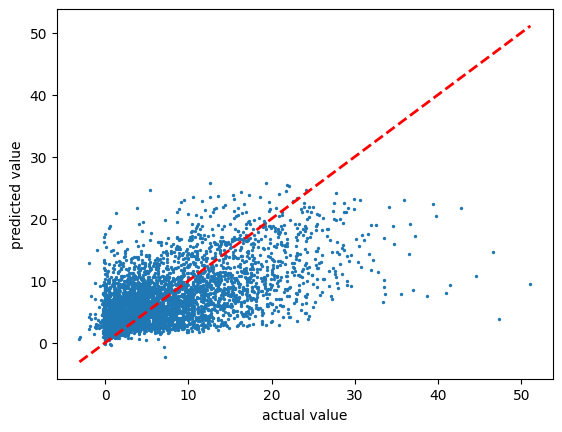

In [377]:
plotResult(y_test, xgb.predict(X_test))

In [378]:
mean_absolute_error(y_test, xgb.predict(X_test))


np.float32(3.9815466)

# Vorhersage 2024

In [379]:
# df_weekly_2024 = nfl.import_weekly_data([2024])
# df_weekly_2024 = df_weekly_2024[df_weekly_2024['season_type'] == 'REG']
# df_weekly_2024['game_id_home_away'] = df_weekly_2024['season'].astype(str) + '_' + df_weekly_2024['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly_2024['recent_team']+'_'+df_weekly_2024['opponent_team']
# df_weekly_2024['game_id_away_home'] = df_weekly_2024['season'].astype(str) + '_' + df_weekly_2024['week'].apply(lambda x: f"{x:02d}")+'_'+df_weekly_2024['opponent_team']+'_'+df_weekly_2024['recent_team']

# # Kombiniere die 2024-Daten mit den vorhandenen Daten
# df_merged_2024 = pd.melt(
#     df_weekly_2024,
#     id_vars=['player_id', 'position', 'season', 'week', 'recent_team', 'opponent_team', 'completions', 'attempts', 'passing_yards', 'passing_tds', 'passing_2pt_conversions', 'interceptions', 'sack_fumbles_lost', 'carries', 'rushing_yards', 'rushing_tds', 'rushing_2pt_conversions', 'rushing_fumbles_lost', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 'receiving_2pt_conversions', 'receiving_fumbles_lost', 'fantasy_points'],
#     value_vars=['game_id_home_away', 'game_id_away_home'],
#     var_name='game_id_type',
#     value_name='game_id'
# )

# def last(group):
#     # Nur nicht-NaN-Werte berücksichtigen
#     return group.dropna().iloc[-1] if not group.dropna().empty else np.nan

# future_features = df_merged.groupby('player_id').agg({
#     'ewm_completions': 'last',
#     'ewm_attempts': 'last', 
#     'ewm_passing_yards': 'last',
#     'ewm_carries': 'last', 
#     'ewm_rushing_yards': 'last', 
#     'ewm_receptions':'last', 
#     'ewm_targets': 'last',
#     'ewm_receiving_yards': 'last', 
#     'ewm_fantasy_points': 'last', 
#     'ewm_turnover': 'last',
#     'ewm_rushing_pts': 'last', 
#     'ewm_receiving_pts': 'last', 
#     'ewm_passing_pts': 'last'
#     }).reset_index()


# df_merged_2024 = pd.merge(df_merged_2024[['player_id', 'position', 'season', 'week', 'game_id', 'recent_team', 'opponent_team', 'fantasy_points']], df_draft[['player_id', 'pick']], on='player_id', how='left')
# df_merged_2024['player_id'] = df_merged_2024['player_id'].str.replace('00-00', '').astype(int)
# df_merged_2024 = pd.merge(df_merged_2024, future_features, on='player_id', how='left')
# df_merged_2024 = pd.merge(df_merged_2024, df_schedule[['game_id', 'home_team', 'roof', 'surface', 'wind', 'temp']], on='game_id', how='inner')

# df_merged_2024 = df_merged_2024.drop(columns='game_id')

# df_merged_2024['home'] = (df_merged_2024['home_team'] == df_merged_2024['recent_team']).astype(int)
# df_merged_2024 = df_merged_2024.drop(columns=['home_team'])

# df_merged_2024



# X_2024 = df_merged_2024.drop(columns=['fantasy_points'])
# y_2024 = df_merged_2024['fantasy_points']

# # Vorhersage für 2024
# y_pred_2024 = xgb.predict(X_2024)

# # Ausgabe der Vorhersagen
# df_merged_2024['predicted_fantasy_points'] = y_pred_2024

# # Erstelle die gewünschte CSV-Datei mit den notwendigen Spalten
# output_df = df_merged_2024[['player_id', 'season', 'week', 'recent_team', 'opponent_team', 'predicted_fantasy_points', 'fantasy_points']]

# # Speichern der Ergebnisse in eine CSV-Datei
# output_df.to_csv('fantasy_points_predictions_2024.csv', index=False)

# # Zeige die ersten Zeilen der exportierten Datei an
# output_df.head()